Camera will capture frame...


<IPython.core.display.Javascript object>

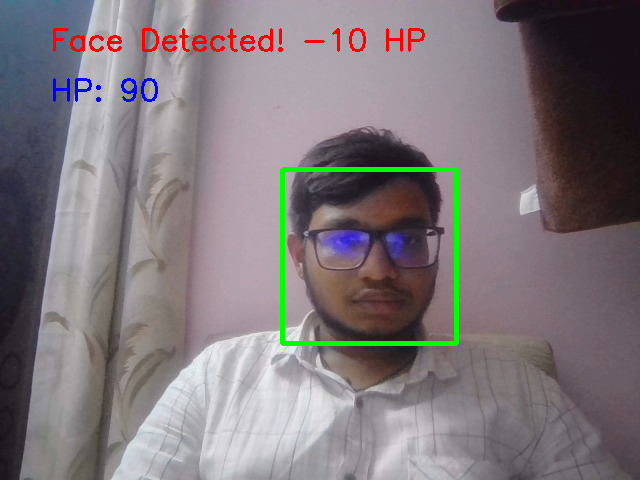

<IPython.core.display.Javascript object>

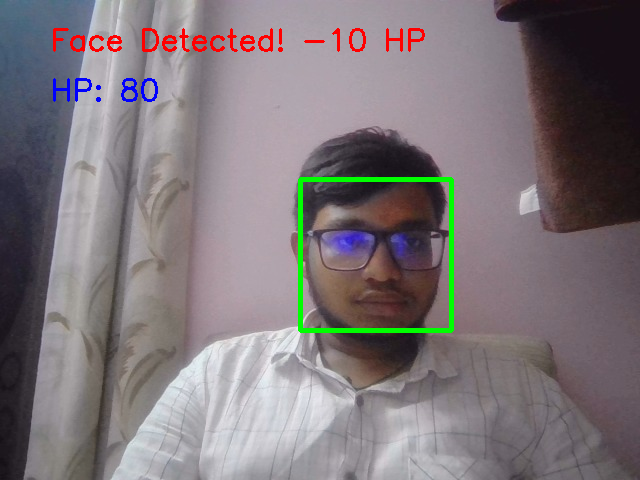

<IPython.core.display.Javascript object>

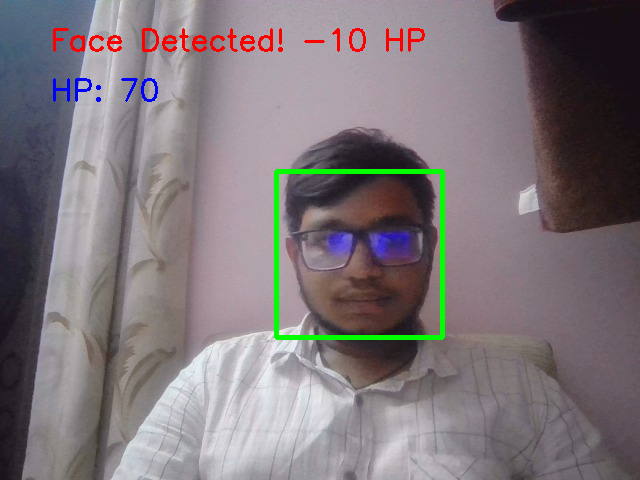

<IPython.core.display.Javascript object>

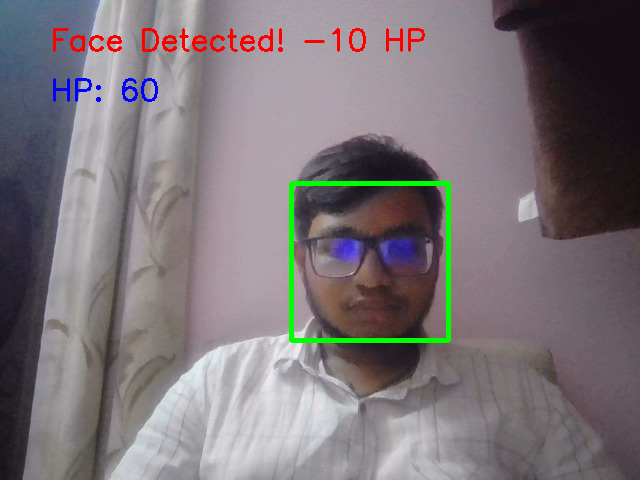

<IPython.core.display.Javascript object>

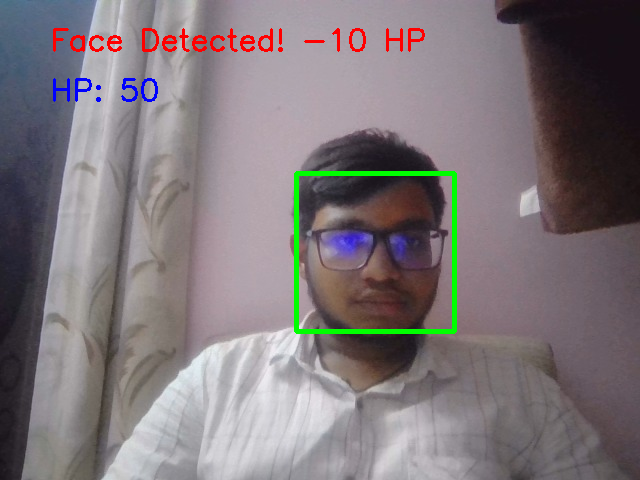

<IPython.core.display.Javascript object>

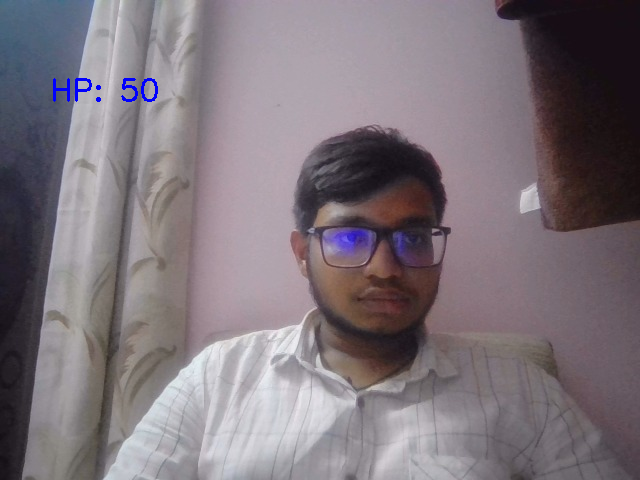

<IPython.core.display.Javascript object>

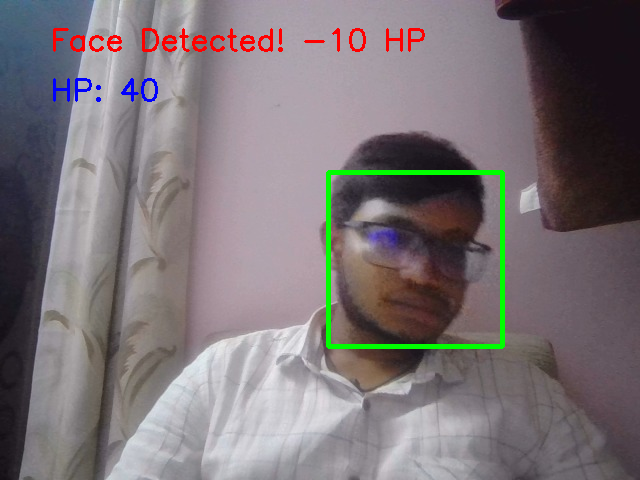

<IPython.core.display.Javascript object>

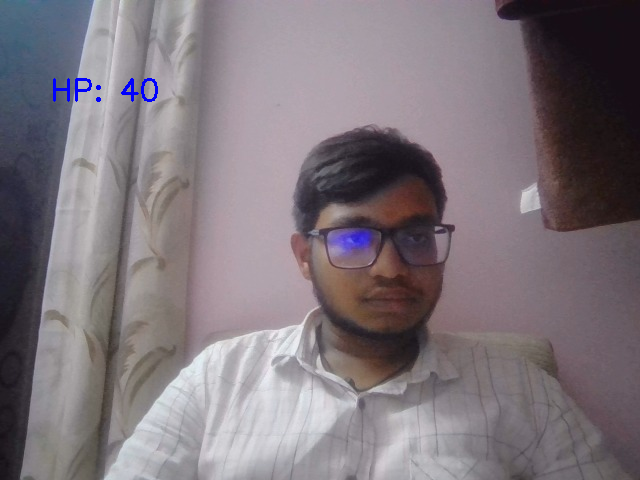

<IPython.core.display.Javascript object>

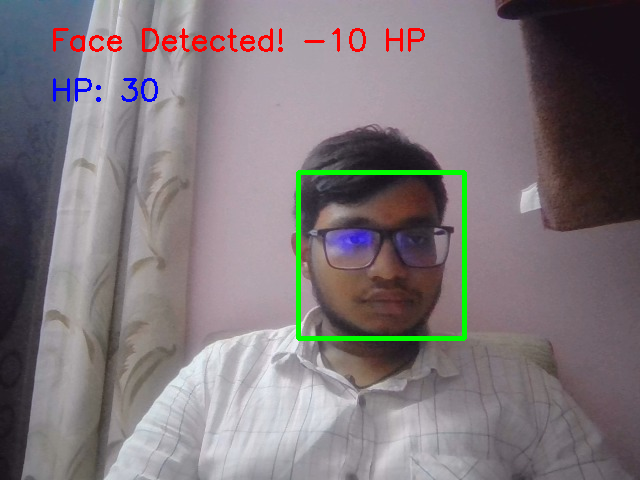

<IPython.core.display.Javascript object>

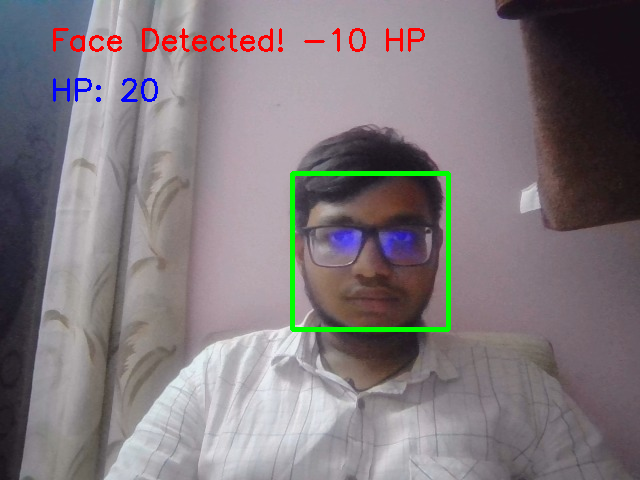

<IPython.core.display.Javascript object>

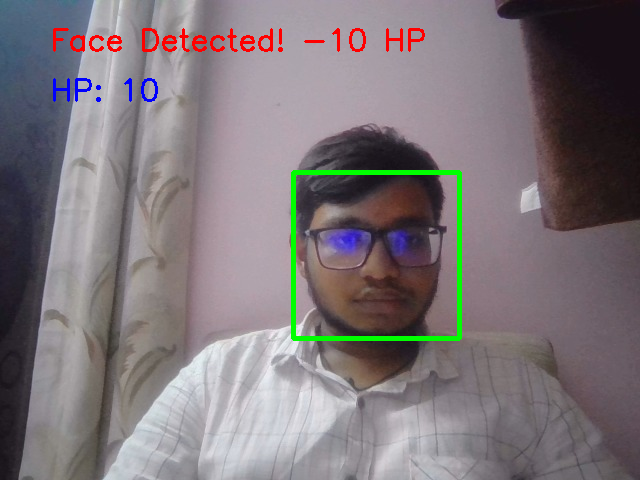

<IPython.core.display.Javascript object>

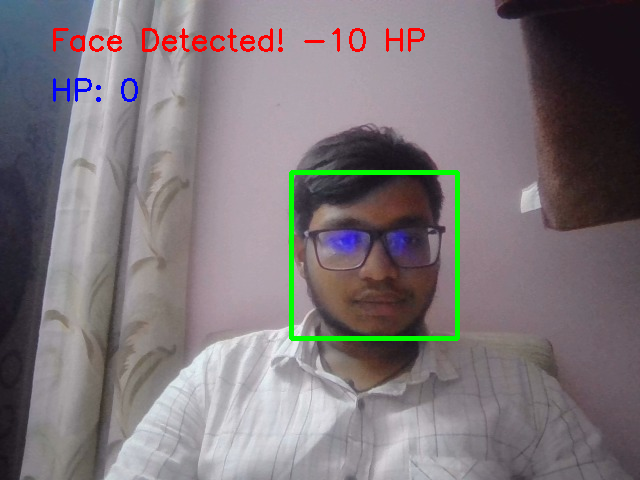

GAME OVER


In [6]:
# Install OpenCV
!pip install opencv-python --quiet

import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import output
from IPython.display import Javascript, display
import base64
import time

# Start camera (Colab browser capture)
def take_photo():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();
            await new Promise(resolve => setTimeout(resolve, 1000));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('takePhoto()')
    binary = base64.b64decode(data.split(',')[1])
    image = np.frombuffer(binary, dtype=np.uint8)
    return cv2.imdecode(image, cv2.IMREAD_COLOR)

from google.colab.output import eval_js

# Load face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

player_hp = 100

print("Camera will capture frame...")

while player_hp > 0:
    frame = take_photo()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 3)
        player_hp -= 10
        cv2.putText(frame, "Face Detected! -10 HP",
                    (50,50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,0,255), 2)

    cv2.putText(frame, f"HP: {player_hp}",
                (50,100),
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (255,0,0), 2)

    cv2_imshow(frame)

    if player_hp <= 0:
        print("GAME OVER")
        break


Show your hand to the camera...


<IPython.core.display.Javascript object>

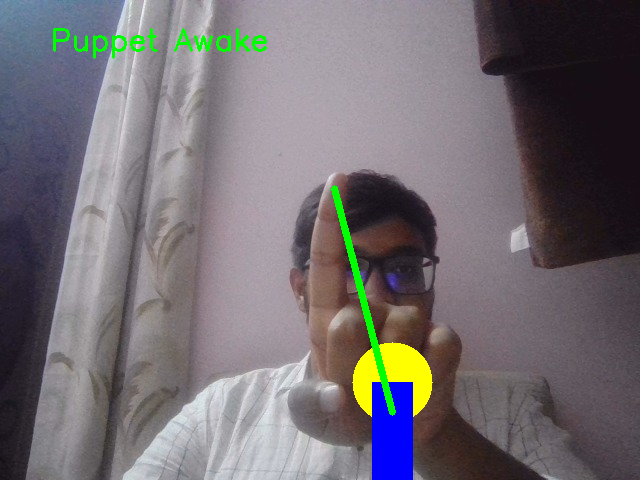

Press ENTER to continue or q to quit: o


<IPython.core.display.Javascript object>

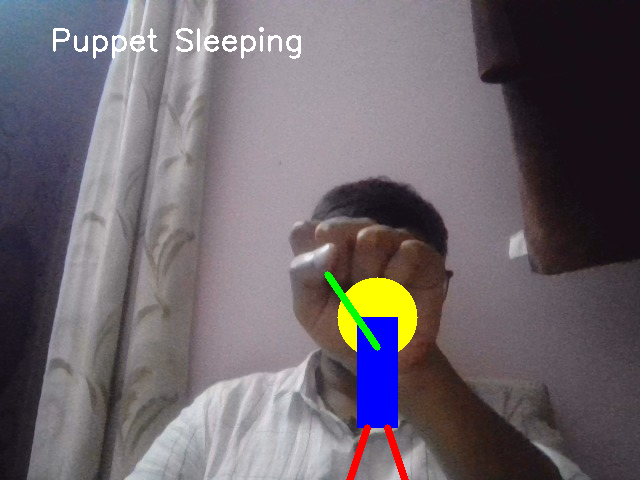

Press ENTER to continue or q to quit: q


In [11]:
# Install latest mediapipe
!pip install mediapipe opencv-python --quiet

import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from IPython.display import Javascript, display
import base64
import tempfile

# ----------------------------
# Webcam Capture (Colab)
# ----------------------------
def capture_frame():
    js = Javascript('''
        async function capture() {
            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();
            await new Promise(resolve => setTimeout(resolve, 100));
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('capture()')
    binary = base64.b64decode(data.split(',')[1])
    image = np.frombuffer(binary, dtype=np.uint8)
    return cv2.imdecode(image, cv2.IMREAD_COLOR)

# ----------------------------
# MediaPipe Tasks API Setup
# ----------------------------
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Download hand model
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(
    base_options=base_options,
    num_hands=1
)

detector = vision.HandLandmarker.create_from_options(options)

print("Show your hand to the camera...")

while True:
    frame = capture_frame()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
    result = detector.detect(mp_image)

    h, w, _ = frame.shape

    if result.hand_landmarks:
        hand = result.hand_landmarks[0]

        wrist = hand[0]
        cx, cy = int(wrist.x * w), int(wrist.y * h)

        thumb_tip = hand[4]
        index_tip = hand[8]

        distance = np.sqrt(
            (thumb_tip.x - index_tip.x)**2 +
            (thumb_tip.y - index_tip.y)**2
        )

        # Draw puppet
        cv2.circle(frame, (cx, cy-50), 40, (0,255,255), -1)
        cv2.rectangle(frame, (cx-20, cy-50),
                      (cx+20, cy+60), (255,0,0), -1)

        ix, iy = int(index_tip.x*w), int(index_tip.y*h)
        cv2.line(frame, (cx, cy-20), (ix, iy), (0,255,0), 5)

        cv2.line(frame, (cx-10, cy+60),
                 (cx-30, cy+120), (0,0,255), 5)
        cv2.line(frame, (cx+10, cy+60),
                 (cx+30, cy+120), (0,0,255), 5)

        if distance < 0.05:
            cv2.putText(frame, "Puppet Sleeping",
                        (50,50),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, (255,255,255), 2)
        else:
            cv2.putText(frame, "Puppet Awake",
                        (50,50),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0,255,0), 2)

    cv2_imshow(frame)

    key = input("Press ENTER to continue or q to quit: ")
    if key.lower() == 'q':
        break
